### Libraries Import

In [1]:
import torch
import torch.nn as nn

### Net definition

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_size = 196608
        self.fc1 = nn.Linear(self.input_size, 50)
        self.fc2 = nn.Linear(50,2)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

net = Net()

#### Count params

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
count_parameters(net)

9830552

### Input image

In [5]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

#### DataLoader

In [6]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.flatten())])
image_folder = dset.ImageFolder("chihuahua-vs-muffin/processed_data/train/", transform)
trainloader = torch.utils.data.DataLoader(image_folder,batch_size = 4,shuffle = True, num_workers=8)

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

#### Images visualisation

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
import numpy as np

In [9]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(15,9))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

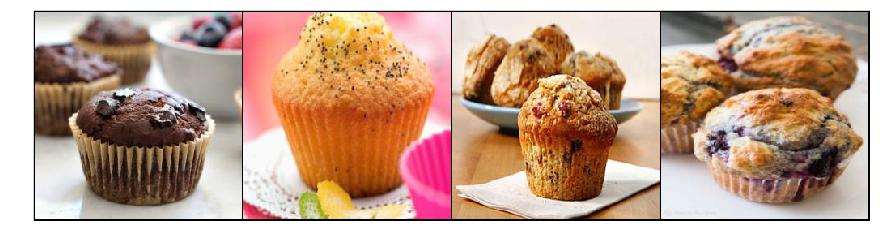

In [10]:
# show images
imshow(torchvision.utils.make_grid(images.reshape([4,3,256,256])))

In [11]:
classes=('chihuahua','muffin')
print('Classes :' + ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Classes :muffin muffin muffin muffin


#### Make prediction

In [12]:
outputs = net(images)

#### Check prediction

In [13]:
_, predicted = torch.max(outputs.data, 1)
print('Prediction: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Prediction:  muffin muffin muffin muffin


### Train the model

#### Define a Loss

In [14]:
criterion = nn.CrossEntropyLoss()

#### Define an Optimizer

In [15]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))

#### Define a training Loop

In [16]:
batch_size = 32
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.flatten())])
trainloader = torch.utils.data.DataLoader(dset.ImageFolder("chihuahua-vs-muffin/processed_data/train/", transform),batch_size = 8,shuffle = True, num_workers=8)

In [17]:
%%time
for i, data in enumerate(trainloader):
    # get the inputs
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

print('Finished Training')

Finished Training
CPU times: user 19.1 s, sys: 2.83 s, total: 21.9 s
Wall time: 6.24 s


#### Mesuring performances

In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the images: %f %%' % (100*float(correct) / total))

Accuracy of the network on the images: 0.612789 %


#### Validation dataset

In [19]:
validation_loader = torch.utils.data.DataLoader(dset.ImageFolder("chihuahua-vs-muffin/processed_data/validation/", transform),batch_size=batch_size,shuffle=True)

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the images: %f %%' % (float(correct) / total))

Accuracy of the network on the images: 0.556522 %


## GPU

#### Model creation

In [21]:
device = torch.device("cuda:0")
cuda_net = Net().to(device)

#### Parameters

In [22]:
for p in cuda_net.parameters():
    print(p.device, p.size())
    
for p in net.parameters():
    print(p.device, p.size())

cuda:0 torch.Size([50, 196608])
cuda:0 torch.Size([50])
cuda:0 torch.Size([2, 50])
cuda:0 torch.Size([2])
cpu torch.Size([50, 196608])
cpu torch.Size([50])
cpu torch.Size([2, 50])
cpu torch.Size([2])


#### Optimizer and loader

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cuda_net.parameters(), lr=0.00001, betas=(0.9, 0.999))
trainloader = torch.utils.data.DataLoader(dset.ImageFolder("chihuahua-vs-muffin/processed_data/train/", transform),batch_size = 8,shuffle = True, num_workers=8)

#### Training Loop

In [24]:
%%time
for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = cuda_net(inputs.to(device))
    loss = criterion(outputs, labels.to(device))
    loss.backward()
    optimizer.step()

print('Finished Training')

Finished Training
CPU times: user 925 ms, sys: 665 ms, total: 1.59 s
Wall time: 1.68 s


#### Training Loop - Several epochs

In [25]:
%%time
for epoch in range(10):
    #running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cuda_net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

print('Finished Training')

Finished Training
CPU times: user 9.45 s, sys: 7.12 s, total: 16.6 s
Wall time: 17.3 s


#### Performance

In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = cuda_net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(correct)
print(total)
print('Accuracy of the network on the 10000 test images: %f %%' % (float(correct) / total))

505
563
Accuracy of the network on the 10000 test images: 0.896980 %


#### Real performance

In [27]:
#transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
validationloader = torch.utils.data.DataLoader(dset.ImageFolder("chihuahua-vs-muffin/processed_data/validation/", transform),batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(dset.ImageFolder("chihuahua-vs-muffin/processed_data/test/", transform),batch_size=batch_size,shuffle=True)

In [28]:
correct = 0
total = 0

with torch.no_grad():
    for data in validationloader:
        images, labels = data
        outputs = cuda_net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(correct)
print(total)
print('Accuracy of the network on the validation images: %f %%' % (100*float(correct) / total))


correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cuda_net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

        
print(correct)
print(total)
print('Accuracy of the network on the 16 test images: %f %%' % (100*float(correct) / total))

95
115
Accuracy of the network on the validation images: 82.608696 %
8
16
Accuracy of the network on the 16 test images: 50.000000 %


### Learning with Visdom

#### Lib

In [29]:
from torchnet.engine import Engine
from torchnet.logger import VisdomPlotLogger, VisdomLogger
import torchnet as tnt
import visdom

#### Visom init

In [30]:
vis = visdom.Visdom()
vis.close(env="Chihuahua VS Muffin")
meter_loss = tnt.meter.AverageValueMeter()
classerr =  tnt.meter.ClassErrorMeter(accuracy=True)
confusion_meter = tnt.meter.ConfusionMeter(2)

loss_logger = VisdomPlotLogger('line', env = "Chihuahua VS Muffin", opts={'title': 'Loss'})
acc_logger = VisdomPlotLogger('line', env = "Chihuahua VS Muffin", opts={'title': 'Accuracy'})
confusion_logger = VisdomLogger('heatmap', env = "Chihuahua VS Muffin", opts={'title': 'Confusion matrix','columnnames': ['chihuahua','muffin'],'rownames': ['chihuahua','muffin']})

#### Epoch functions

In [31]:
def on_forward():
    meter_loss.add(loss.item())
    classerr.add(outputs.detach(), labels.to(device).detach())
    
def on_start_epoch():
    reset_meters()
    
def on_end_epoch(model,inputs_validation, labels_validation):
    loss_logger.log(epoch, meter_loss.value()[0],name='train')
    acc_logger.log(epoch, classerr.value()[0],name='train')
    
    classerr.reset()
    with torch.no_grad():
        outputs = model(inputs_validation.to(device))
        loss = criterion(outputs, labels_validation.to(device))
        classerr.add(outputs.detach(), labels_validation.to(device).detach())
        confusion_meter.add(outputs.detach(), labels_validation.to(device).detach())
        
    confusion_logger.log(confusion_meter.value())
    loss_logger.log(epoch, loss.item(),name='validation')
    acc_logger.log(epoch, classerr.value()[0],name='validation')
    
def reset_meters():
    meter_loss.reset()
    classerr.reset()
    confusion_meter.reset()

#### Init loader, optimizer, net

In [32]:
device = torch.device("cuda:0")
cuda_net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cuda_net.parameters(), lr=0.00001, betas=(0.9, 0.999))
trainloader = torch.utils.data.DataLoader(dset.ImageFolder("chihuahua-vs-muffin/processed_data/train/", transform),batch_size=batch_size,shuffle=True)
validationloader = torch.utils.data.DataLoader(dset.ImageFolder("chihuahua-vs-muffin/processed_data/validation/", transform),batch_size=128,shuffle=True)
testloader = torch.utils.data.DataLoader(dset.ImageFolder("chihuahua-vs-muffin/processed_data/test/", transform),batch_size=batch_size,shuffle=True)
iterator_validation = iter(validationloader)
inputs_validation, labels_validation = iterator_validation.next()

#### Learning Loop with epoch fonctions

In [33]:
%%time

nb_epochs = 100
for epoch in range(nb_epochs):
    on_start_epoch()
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = cuda_net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        on_forward()
        
    on_end_epoch(cuda_net,inputs_validation, labels_validation)

CPU times: user 6min 44s, sys: 13.3 s, total: 6min 58s
Wall time: 2min 28s


## Convolution

In [34]:
class ModelCNNDropout(nn.Module):

    def __init__(self):
        super(ModelCNNDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, (5, 5))
        self.conv2 = nn.Conv2d(4, 8, (5, 5))
        self.conv3 = nn.Conv2d(8, 12, (5, 5))
        self.conv4 = nn.Conv2d(12, 16, (5, 5))
        self.fc1 = nn.Linear(2304, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, input_):
        h1 = torch.relu(torch.nn.functional.max_pool2d(self.conv1(input_), 2))
        h1 = torch.nn.functional.dropout(h1, p=0.8, training=self.training)
        h2 = torch.relu(torch.nn.functional.max_pool2d(self.conv2(h1), 2))
        h2 = torch.nn.functional.dropout(h2, p=0.8, training=self.training)
        h3 = torch.relu(torch.nn.functional.max_pool2d(self.conv3(h2), 2))
        h3 = torch.nn.functional.dropout(h3, p=0.8, training=self.training)
        h4 = torch.relu(torch.nn.functional.adaptive_max_pool2d(self.conv4(h3), (12,12)))
        h4 = torch.nn.functional.dropout(h4, p=0.8, training=self.training)
    
        h4 = h4.view(-1, 2304)
        h5 = torch.relu(self.fc1(h4))
        h5 = torch.nn.functional.dropout(h5, p=0.8, training=self.training)
        h6 = self.fc2(h5)
        return h6

In [35]:
class ModelCNN(nn.Module):
    def __init__(self):
        super(ModelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, (5, 5))
        self.conv2 = nn.Conv2d(4, 8, (5, 5))
        self.conv3 = nn.Conv2d(8, 12, (5, 5))
        self.conv4 = nn.Conv2d(12, 16, (5, 5))
        self.fc1 = nn.Linear(2304, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, input_):
        h1 = torch.relu(torch.nn.functional.max_pool2d(self.conv1(input_), 2))
        h2 = torch.relu(torch.nn.functional.max_pool2d(self.conv2(h1), 2))
        h3 = torch.relu(torch.nn.functional.max_pool2d(self.conv3(h2), 2))
        h4 = torch.relu(torch.nn.functional.adaptive_max_pool2d(self.conv4(h3), (12,12)))
        h4 = h4.view(-1, 2304)
        h5 = torch.relu(self.fc1(h4))
        h6 = self.fc2(h5)
        return h6

In [36]:
cnn_net = ModelCNN().to(device)
count_parameters(cnn_net)

598934

In [37]:
cnn_net_dropout = ModelCNNDropout().to(device)
count_parameters(cnn_net_dropout)

598934

In [38]:
def reset_meters():
    meter_loss.reset()
    classerr.reset()
    confusion_meter.reset()

def on_forward():
    meter_loss.add(loss.item())
    classerr.add(outputs.detach(), labels.to(device).detach())

def on_start_epoch():
    reset_meters()

def on_end_epoch(model,inputs_validation, labels_validation):
    loss_logger.log(epoch, meter_loss.value()[0],name='train')
    acc_logger.log(epoch, classerr.value()[0],name='train')
    
    classerr.reset()
    with torch.no_grad():
        outputs = model(inputs_validation.to(device))
        loss = criterion(outputs, labels_validation.to(device))
        classerr.add(outputs.detach(), labels_validation.to(device).detach())
        confusion_meter.add(outputs.detach(), labels_validation.to(device).detach())
        
    confusion_logger.log(confusion_meter.value())
    loss_logger.log(epoch, loss.item(),name='validation')
    acc_logger.log(epoch, classerr.value()[0],name='validation')

In [39]:
batch_size=32
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_net.parameters(), lr=0.001, betas=(0.9, 0.999))
trainloader = torch.utils.data.DataLoader(dset.ImageFolder("chihuahua-vs-muffin/processed_data/train/", transforms.ToTensor()),batch_size=batch_size,shuffle=True,num_workers=8)
validationloader = torch.utils.data.DataLoader(dset.ImageFolder("chihuahua-vs-muffin/processed_data/validation/", transforms.ToTensor()),batch_size=128,shuffle=True,num_workers=8)
testloader = torch.utils.data.DataLoader(dset.ImageFolder("chihuahua-vs-muffin/processed_data/test/", transforms.ToTensor()),batch_size=batch_size,shuffle=True,num_workers=8)

In [40]:
%%time

vis = visdom.Visdom()
#vis.close(env="Chihuahua VS Muffin")
meter_loss = tnt.meter.AverageValueMeter()
classerr =  tnt.meter.ClassErrorMeter(accuracy=True)
confusion_meter = tnt.meter.ConfusionMeter(2)

loss_logger = VisdomPlotLogger('line', env = "Chihuahua VS Muffin", opts={'title': 'Loss Conv'})
acc_logger = VisdomPlotLogger('line', env = "Chihuahua VS Muffin", opts={'title': 'Accuracy Conv'})
confusion_logger = VisdomLogger('heatmap', env = "Chihuahua VS Muffin", opts={'title': 'Confusion matrix Conv','columnnames': ['chihuahua','muffin'],'rownames': ['chihuahua','muffin']})

iterator_validation = iter(validationloader)
inputs_validation, labels_validation = iterator_validation.next()

nb_epochs = 100
for num_epoch, epoch in enumerate(range(nb_epochs)):
    on_start_epoch()
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = cnn_net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        on_forward()
    on_end_epoch(cnn_net,inputs_validation, labels_validation)

CPU times: user 2min 24s, sys: 1min 31s, total: 3min 56s
Wall time: 4min 24s


In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_net_dropout.parameters(), lr=0.001, betas=(0.9, 0.999))
trainloader = torch.utils.data.DataLoader(dset.ImageFolder("chihuahua-vs-muffin/processed_data/train/", transforms.ToTensor()),batch_size=batch_size,shuffle=True,num_workers=8)
validationloader = torch.utils.data.DataLoader(dset.ImageFolder("chihuahua-vs-muffin/processed_data/validation/", transforms.ToTensor()),batch_size=128,shuffle=True,num_workers=8)
testloader = torch.utils.data.DataLoader(dset.ImageFolder("chihuahua-vs-muffin/processed_data/test/", transforms.ToTensor()),batch_size=batch_size,shuffle=True,num_workers=8)

In [42]:
%%time

vis = visdom.Visdom()
#vis.close(env="Chihuahua VS Muffin")
meter_loss = tnt.meter.AverageValueMeter()
classerr =  tnt.meter.ClassErrorMeter(accuracy=True)
confusion_meter = tnt.meter.ConfusionMeter(2)

loss_logger = VisdomPlotLogger('line', env = "Chihuahua VS Muffin", opts={'title': 'Loss with Dropout'})
acc_logger = VisdomPlotLogger('line', env = "Chihuahua VS Muffin", opts={'title': 'Accuracy with Dropout'})
confusion_logger = VisdomLogger('heatmap', env = "Chihuahua VS Muffin", opts={'title': 'Confusion matrix with Dropout','columnnames': ['chihuahua','muffin'],'rownames': ['chihuahua','muffin']})

iterator_validation = iter(validationloader)
inputs_validation, labels_validation = iterator_validation.next()

nb_epochs = 100
for num_epoch, epoch in enumerate(range(nb_epochs)):
    on_start_epoch()
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = cnn_net_dropout(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        on_forward()
    on_end_epoch(cnn_net_dropout,inputs_validation, labels_validation)   

CPU times: user 2min 46s, sys: 1min 40s, total: 4min 26s
Wall time: 4min 57s


## Feature extraction

In [ ]:
import numpy as np
def extraire_features_label_et_datas(loader):
    k=0
    for batch_idx, (data, target) in enumerate(loader):
        data = data.to(device)
        output = model_ft(data)
        array = output.detach().cpu().numpy()
        if k==0:
            features=array
            labels=target.numpy()
            datas=data.detach().cpu().numpy()
        else:
            features=np.concatenate((features,array),axis=0)
            labels=np.concatenate((labels,target.numpy()))
            datas=np.concatenate((datas,data.data.cpu().numpy()),axis=0)
        k=k+1
    features=np.reshape(features,(features.shape[0],features.shape[1]*features.shape[2]*features.shape[3]))
    datas=np.transpose(datas,(0,2,3,1))
    return features,labels,datas

#### Load VGG model

In [43]:
from torchvision import models
model_ft = models.vgg16(pretrained=True)

#### Get last Feature Map

In [ ]:
model_ft = torch.nn.Sequential(*list(model_ft.children())[:-1])
model_ft = model_ft.to(device)

#### Parameters

In [ ]:
count_parameters(model_ft)

#### Loader init

In [ ]:
trainloader = torch.utils.data.DataLoader(dset.ImageFolder("chihuahua-vs-muffin/processed_data/train/", transforms.ToTensor()),batch_size=4,shuffle=True,num_workers=8)
validationloader = torch.utils.data.DataLoader(dset.ImageFolder("chihuahua-vs-muffin/processed_data/validation/", transforms.ToTensor()),batch_size=4,shuffle=True,num_workers=8)
testloader = torch.utils.data.DataLoader(dset.ImageFolder("chihuahua-vs-muffin/processed_data/test/", transforms.ToTensor()),batch_size=4,shuffle=True,num_workers=8)

#### Feature extraction

In [ ]:
features_train, labels_train, datas_train = extraire_features_label_et_datas(trainloader)
features_validation, labels_validation, datas_validation = extraire_features_label_et_datas(validationloader)
features_test, labels_test, datas_test = extraire_features_label_et_datas(testloader)

### Feature visualisations

#### Libs

In [ ]:
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from utils.canvas_embedding import *

#### Umap

In [ ]:
embed=umap.UMAP().fit_transform(features_train)

#### Scatter plot

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(embed[:,0],embed[:,1],c=labels_train)

#### Canvas

In [ ]:
canvas = image_scatter(embed,datas_train,100)
plt.figure(figsize=(100,100))
plt.imshow(canvas)

### SVM Classification

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

clf=SVC()
clf.fit(features_train,labels_train)

#### Validation dataset

In [ ]:
print('Score= ',clf.score(features_validation,labels_validation)*100, '%')
y_pred=clf.predict(features_validation)
confusion_matrix(labels_validation,y_pred)

#### Final Test

In [ ]:
print('Score= ',clf.score(features_test,labels_test)*100, '%')

y_pred=clf.predict(features_test)
confusion_matrix(labels_test,y_pred)